This is an example used in the paper illustrate the better performance of our Proposed Path guided Particle based Sample (PGPS) over KL gradient flow based method (Langevean Dynamic (LD) as an example)

In [1]:
#imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.distributions as D
import torch.optim as optim
import time
import os
from scipy.optimize import minimize
import math
import matplotlib
import torch
import seaborn as sns

In [2]:
P0 = D.MultivariateNormal(2 * torch.tensor([0., 0]), torch.tensor([[.1, 0.], [0, .1]])) #Initial Distribution
mix = D.Categorical(torch.ones(2, ))
comp = D.Independent(D.Normal(
    torch.tensor([[1.5, 0], [1, .0]]),
    torch.ones(2, 2) * 0.05), 1)
P1 = D.MixtureSameFamily(mix, comp)#Target Distribution

This is the iid sample of the target distribution

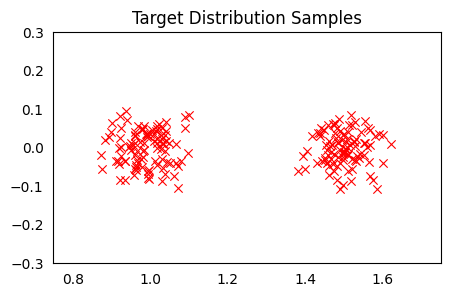

In [3]:
X1 = P1.sample(torch.Size([200]))
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X1[:, 0], X1[:, 1], marker='x', label='sample', c='r', alpha=1., linewidths=0.8)
ax.tick_params(left=False, bottom=False)
plt.xlim([0.75, 1.75])
plt.ylim([-0.3, 0.3])
plt.title('Target Distribution Samples')
plt.show()

Now we perform LD for 4000 iterations

In [4]:
class LangenvianMonteCarlo():
    def __init__(self, p):
        self.p = p

    def one_step(self, X, dt):
        X = X.detach().requires_grad_(True)
        log_l = self.p.log_prob(X)
        score_funcs = torch.autograd.grad(log_l.sum(), X)[0].detach()
        X = X + dt * score_funcs + math.sqrt(2 * dt) * torch.randn_like(X)
        return X

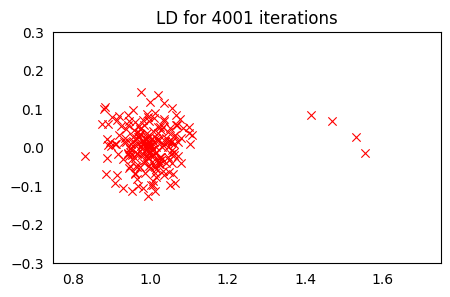

In [5]:
steps = 4001
langenvian = LangenvianMonteCarlo(P1)
X = P0.sample(torch.Size([200]))
for i in range(steps):
    X = langenvian.one_step(X, 0.001)
with torch.no_grad():
  fig = plt.figure(figsize=(5, 3))
  ax = fig.add_subplot(1, 1, 1)
  ax.scatter(X[:, 0], X[:, 1], marker='x', label='sample', c='r', alpha=1., linewidths=0.8)
  ax.tick_params(left=False, bottom=False)

  plt.xlim([0.75, 1.75])
  plt.ylim([-0.3, 0.3])
  plt.title(f'LD for {steps} iterations')
  plt.show()

Now we perform PGPS over the same initial and target distribution

In [6]:
#Define some utilities

class Net_X(torch.nn.Module):
    def __init__(self, x_dim, width):
        super().__init__()
        self.il = nn.Linear(x_dim, width)
        self.act = nn.Sigmoid()
        self.ol = nn.Linear(width, x_dim)

    def forward(self, X):
        x_1 = self.act(self.il(X))
        x_2 = (x_1 * (1 - x_1)).unsqueeze(2)
        mat = self.il.weight * self.ol.weight.t()
        return self.ol(x_1), torch.sum(x_2 * mat.unsqueeze(0), dim=[1, 2])
class Path():
    def __init__(self, P0, P1):
        self.P0 = P0
        self.P1 = P1
    def log_prob(self, t, X):
        raise NotImplementedError

    def derivative_t_log_prob(self, t, X):
        raise NotImplementedError

    def sample_P0(self, size):
        p0s = self.P0.sample(torch.Size([size, ]))
        if len(p0s.shape) == 1:
            p0s = p0s.unsqueeze(-1)
        return p0s


class ExpTelePath(Path):
    def __init__(self, P0, P1, device='cpu', base=0.8, center=0., alpha=0):
        super().__init__(P0, P1)
        self.base = base
        self.center = center
        self.device = device
        self.alpha=alpha

    def log_prob(self, t, X):
        return (1 - t).squeeze() * self.P0.log_prob(X * (1 - self.alpha*t)).squeeze() \
               + t.squeeze() * self.P1.log_prob(X / (self.base + (1 - self.base) * t)).squeeze()

    def derivative_t_log_prob(self, t, X):
        if t.shape == torch.Size([]):
            t = t.item()*torch.ones([X.shape[0], 1], device=self.device)
        t = t.detach().requires_grad_(True)
        logpt = self.log_prob(t, X)
        dlogdt = torch.autograd.grad(logpt.sum(), t)[0].detach()
        return dlogdt.squeeze()

    def derivative_t_log_prob_NN(self, t, X):
        X_0 = ((1 - self.alpha * t) * X).detach().requires_grad_(True)
        X_1 = (X / (self.base + (1 - self.base) * t)).detach().requires_grad_(True)
        P0_score = torch.autograd.grad(self.P0.log_prob(X_0).sum(), X_0)[0].detach()
        P1_score = torch.autograd.grad(self.P1.log_prob(X_1).sum(), X_1)[0].detach()
        dlogdt = -self.P0.log_prob(X_0) + self.P1.log_prob(X_1) - self.alpha*(1-t)*torch.sum(X*P0_score, dim=1) - (1-self.base)*t/(self.base + (1-self.base)*t)**2*torch.sum(X*P1_score, dim=1)
        return dlogdt.squeeze()

    def score_function(self, t, X):
        X_0 = ((1-self.alpha*t)*X).detach().requires_grad_(True)
        X_1 = (X/(self.base + (1-self.base)*t)).detach().requires_grad_(True)
        P0_score = torch.autograd.grad(self.P0.log_prob(X_0).sum(), X_0)[0].detach()
        P1_score = torch.autograd.grad(self.P1.log_prob(X_1).sum(), X_1)[0].detach()
        return (t/(self.base + (1-self.base) * t)).squeeze() * P1_score + ((1-self.alpha*t)*(1 - t)).squeeze() * P0_score
class PGGF_2():
    def __init__(self, path, net, optimizer, sample_num, device='cpu'):
        self.path = path
        self.net = net.to(device)
        self.optim = optimizer
        self.t = torch.tensor(0.).to(device)
        self.X = self.path.sample_P0(sample_num).to(device)
        self.device = device
        self.done = False

    def step(self, dt):
        X = self.X.detach().requires_grad_(True)
        grad_x = self.net(X)[0]
        self.X += dt * grad_x
        self.t += dt.detach()
        if self.t >= 1.:
            self.done = True

    def prepare_training(self, NN=False):
        if not NN:
            X = self.X.detach().requires_grad_(True)
            logt = self.path.log_prob(self.t, X)
            self.score_func = torch.autograd.grad(logt.sum(), X)[0].detach()
            self.B = self.path.derivative_t_log_prob(self.t, X).unsqueeze(1).detach()
            self.B_mean = torch.mean(self.B).detach()
        else:
            X = self.X.detach().requires_grad_(True)
            self.score_func = self.path.score_function(self.t, X)
            self.B = self.path.derivative_t_log_prob(self.t, X).unsqueeze(1).detach()
            self.B_mean = torch.mean(self.B).detach()

    def train_one_iter(self):
        X = self.X.detach().requires_grad_(True)
        St, div = self.net(X)
        # div = divergence_bf(St, X)
        A = torch.sum(self.score_func * St, dim=1) + div
        A = A.unsqueeze(1)
        self.net.train()
        self.optim.zero_grad()
        loss = torch.mean((A + self.B - self.B_mean)**2)
        loss.backward()
        loss_v = loss.detach().item()
        self.optim.step()
        return loss_v

    def step_size_decider(self, epsilon):
        return epsilon/torch.mean(torch.norm(self.net(self.X)[0], p=2, dim=1))

    def adaptive_step(self, epsilon, maximum_step=torch.tensor(0.02)):
        proposed_dt = self.step_size_decider(epsilon)
        proposed_dt = torch.min(torch.tensor([1 - self.t, proposed_dt, maximum_step]))
        self.step(proposed_dt)


    def Langevin_step(self, step_size):
        self.X += self.score_func * step_size + torch.randn_like(self.X) * np.sqrt(2*step_size)

    def Langevin_adjust(self, step_size, NN=False):
        self.prepare_training(NN)
        self.Langevin_step(step_size)

In [7]:
path = ExpTelePath(P0, P1, base=0.1)#Define the path
net = Net_X(2, 64)#Network for vector field approxiamtion
optimizer = torch.optim.Adam(list(net.parameters()), lr=1e-1)
pggf = PGGF_2(path, net, optimizer, 200)


In [8]:
#Perform
ts = []
iterations = 0
for j in range(1000):
    print("Step ", j, ", Starts at t=", pggf.t.item())
    pggf.prepare_training()
    for _ in range(1000):
        v = pggf.train_one_iter()
    pggf.adaptive_step(0.05)
    iterations += 1
    ts.append(pggf.t.detach().clone().item())
    for _ in range(10):
        pggf.Langevin_adjust(0.001)
        iterations += 1
    if pggf.done:
        break
print('The end')
print("Total used", iterations, "iterations")

Step  0 , Starts at t= 0.0
Step  1 , Starts at t= 6.866428884677589e-05
Step  2 , Starts at t= 0.00015902708400972188
Step  3 , Starts at t= 0.00028454960556700826
Step  4 , Starts at t= 0.00045664439676329494
Step  5 , Starts at t= 0.0007430081604979932
Step  6 , Starts at t= 0.001205352135002613
Step  7 , Starts at t= 0.001854916918091476
Step  8 , Starts at t= 0.0028084353543817997
Step  9 , Starts at t= 0.005037020891904831
Step  10 , Starts at t= 0.010634878650307655
Step  11 , Starts at t= 0.02786273881793022
Step  12 , Starts at t= 0.047862738370895386
Step  13 , Starts at t= 0.06786273419857025
Step  14 , Starts at t= 0.08786273002624512
Step  15 , Starts at t= 0.10786272585391998
Step  16 , Starts at t= 0.12786272168159485
Step  17 , Starts at t= 0.14786271750926971
Step  18 , Starts at t= 0.16786271333694458
Step  19 , Starts at t= 0.18786270916461945
Step  20 , Starts at t= 0.2078627049922943
Step  21 , Starts at t= 0.22786270081996918
Step  22 , Starts at t= 0.2478626966476

Scatter plot of the PGPS results indecates that out method indeed captures both modes in the target distribution

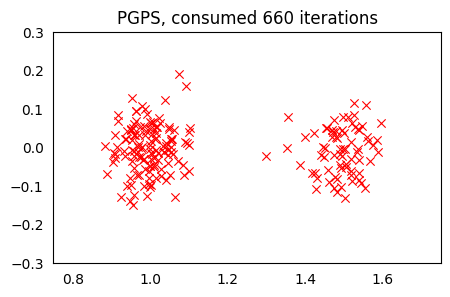

In [9]:
with torch.no_grad():
        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(pggf.X[:, 0], pggf.X[:, 1], marker='x', label='sample', c='r', alpha=1., linewidths=0.8)
        ax.tick_params(left=False, bottom=False)
        plt.xlim([0.75, 1.75])
        plt.ylim([-0.3, 0.3])
        plt.title(f'PGPS, consumed {iterations} iterations')
        plt.show()


Here we plot the t in PGPS over the steps. It can be observed that t temd to be evolve slow in the begining but faster later (linear because of the maximum time step in the algorithm). Our adaptive time-step decision helps find a smoother discretization

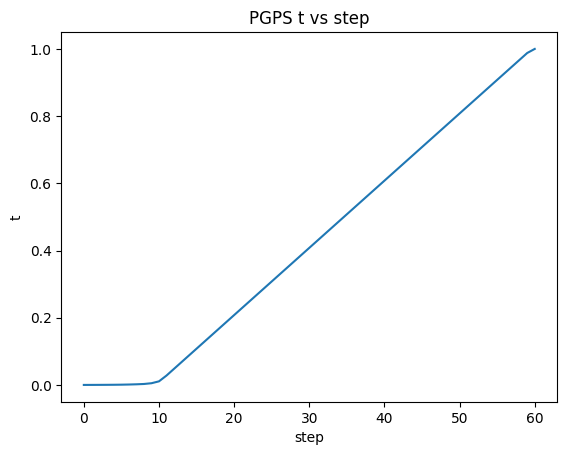

In [10]:
plt.plot(torch.arange(len(ts) + 1), [0.] + ts)
plt.ylabel('t')
plt.xlabel('step')
plt.title('PGPS t vs step')
plt.show()